# Selection of "normal" surface flux year from Tamura and eraInterim datasets
The aim is select a suitable year that represents present day surface forcing for CABROMS. To do so, plot the monthly averages of Tamura sea ice-ocean heat and salt fluxes for all provided years (1992-2007) on top of each other.
Subsequently do the same for wind stress from era interim and  determine a year which does not stand out based on both comparisons . Select the same year. You can't simply use a climatology, since this would kill the high frequency signal in the forcing.

## Tamuras surface heat and salt fluxes
Loading the data (already monthly averages from year 1992-2007 preprocessed from raw data with matlab script read_tamura_daily_to_monthly.m) and explore it.

In [91]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

tamura_data_path = os.path.join(os.pardir,'data','external','tamura','2005-2010_Takeshi_subset_monthly.mat')
tamura_raw = sio.loadmat(tamura_data_path)

In [92]:
for key,value in tamura_raw.items():
    print(key, type(value),np.shape(value))

__header__ <class 'bytes'> ()
__version__ <class 'str'> ()
__globals__ <class 'list'> (0,)
shfluxtmp <class 'numpy.ndarray'> (721, 721, 72)
ssfluxtmp <class 'numpy.ndarray'> (721, 721, 72)


Create Xarray dataset with datetime coordinate

In [94]:
time = pd.date_range('2005-01',periods=np.size(tamura_raw['shfluxtmp'],-1),freq='M')
time_range = pd.period_range('2005-01',periods=np.size(tamura_raw['shfluxtmp'],-1),freq='M')
time_stamp = pd.Timestamp('2005-01')
tamura_ds = xr.Dataset({'shflux':(['X','Y','time'],tamura_raw['shfluxtmp']),
                        'ssflux':(['X','Y','time'],tamura_raw['ssfluxtmp'])},
                    coords={'time':(('time'),time),
                            'time_range':(('time'),time_range),
                            'reference_time':time_stamp})

Make climatology from area averages and calculate monthly anomalies

In [95]:
climatology = tamura_ds.mean(('X','Y')).groupby('time.month').mean('time')
anomalies = tamura_ds.mean(('X','Y')).groupby('time.month') - climatology

To for easy plotting: transfer to pandas dataframe and reorder data to year (1992,1993,...,2007) over month of year (1,2,3,...,12)

In [96]:
anom_df = anomalies.to_dataframe()
anom_df['year'] = anom_df.index.year
anom_df['monthOfYear'] = anom_df.index.month
anom_df = anom_df.pivot(index='monthOfYear',columns='year')

Plot all years on top of each other

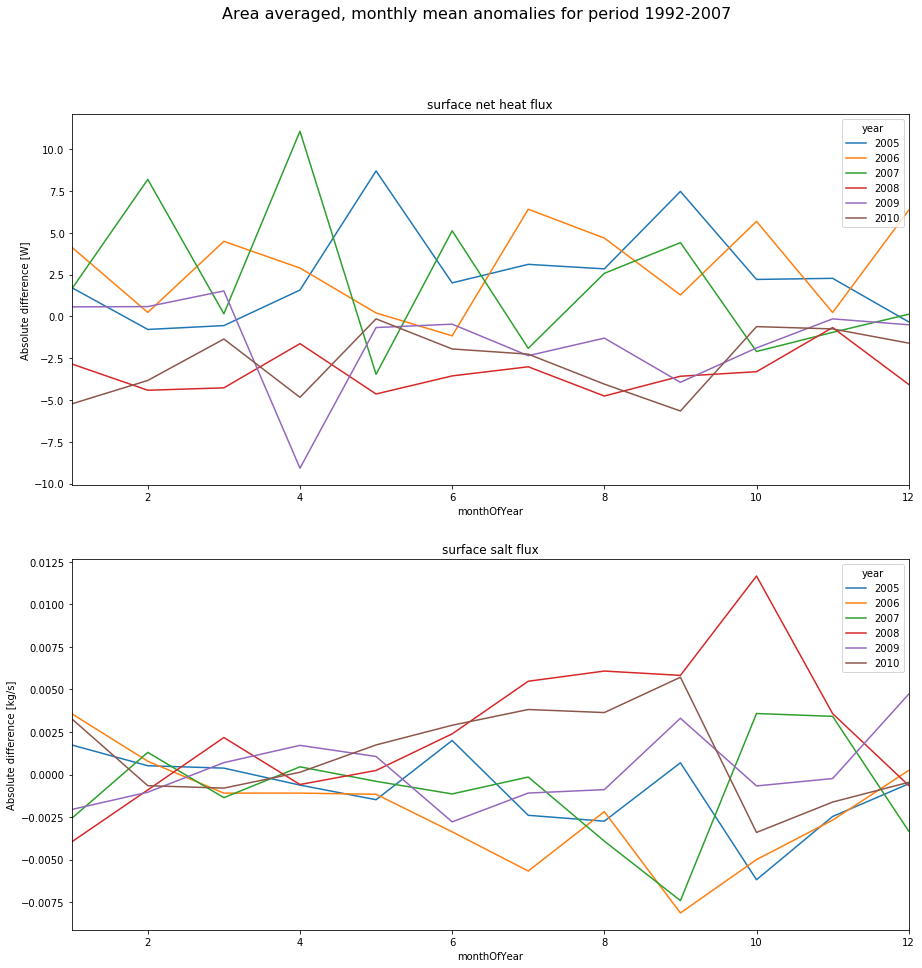

In [97]:
plt.clf()
fig,(ax1,ax2) = plt.subplots(2,figsize=(15,15))
plt.suptitle('Area averaged, monthly mean anomalies for period 1992-2007',fontsize=16)
anom_df['shflux'].plot(ax=ax1)
ax1.set_title('surface net heat flux')
ax1.set_ylabel('Absolute difference [W]')
anom_df['ssflux'].plot(ax=ax2)
ax2.set_title('surface salt flux')
ax2.set_ylabel('Absolute difference [kg/s]')

plt.show()

Display statistics of each year

In [98]:
anom_df['shflux'].describe()

year,2005,2006,2007,2008,2009,2010
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,2.525332,2.957278,2.075191,-3.397239,-1.470785,-2.689777
std,2.918581,2.695282,4.415600,1.235193,2.808495,1.939416
min,-0.779296,-1.163352,-3.463008,-4.763930,-9.082271,-5.659949
25%,1.102108,0.238493,-1.192894,-4.310095,-2.000472,-4.248877
50%,2.110710,3.518962,0.897194,-3.569430,-0.582931,-2.102036
75%,2.914136,4.938002,4.593738,-2.971469,0.032937,-1.201613
max,8.707358,6.414938,11.081825,-0.666123,1.524805,-0.145840


In [99]:
anom_df['ssflux'].describe()

year,2005,2006,2007,2008,2009,2010
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,-0.000926,-0.002149,-0.000960,0.002614,0.000229,0.001192
std,0.002298,0.003141,0.003115,0.004221,0.002190,0.002718
min,-0.006185,-0.008139,-0.007413,-0.003961,-0.002782,-0.003404
25%,-0.002415,-0.003777,-0.002765,-0.000601,-0.001052,-0.000691
50%,-0.000584,-0.001671,-0.000770,0.002284,-0.000453,0.000937
75%,0.000561,-0.000759,0.000666,0.005572,0.001225,0.003371
max,0.002001,0.003578,0.003587,0.011673,0.004727,0.005720


##  EraInterim surface stress
Load data with Xarray and select to southern ocean 1992-2007

In [76]:
import xarray as xr
import pandas as pd

In [100]:
path_era = os.path.join(os.pardir,'data','external','eraInterim','ERA_Interim_1992_2011.2daily.?winds.nc')
era_ds = xr.open_mfdataset(path_era,data_vars='minimal').sel(time=slice('2005-01-01T00:00:00','2010-12-31T24:00:00'),latitude=slice(-40,-75))

calculate daily mean, since this is what you apply to roms

In [102]:
era_ds = era_ds.resample(time='1D').mean()
era_ds.time[-1]

<xarray.DataArray 'time' ()>
array(1293753600000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-12-31

Make climatology from area averages and calculate daily anomalies

In [103]:
climatology = era_ds.mean(("latitude",'longitude')).groupby('time.day').mean('time')
anomaly = era_ds.mean(("latitude",'longitude')).groupby('time.day') - climatology

To for easy plotting: transfer to pandas dataframe and reorder data to year (2005,2006,...,2010) over day of year (1,2,3,...,365)

In [104]:
anom_df = anomaly.to_dataframe()
anom_df['year'] = anom_df.index.year
anom_df['dayOfYear'] = anom_df.index.dayofyear
anom_df = anom_df.pivot(index='dayOfYear',columns='year')

Plot all years on top of each other

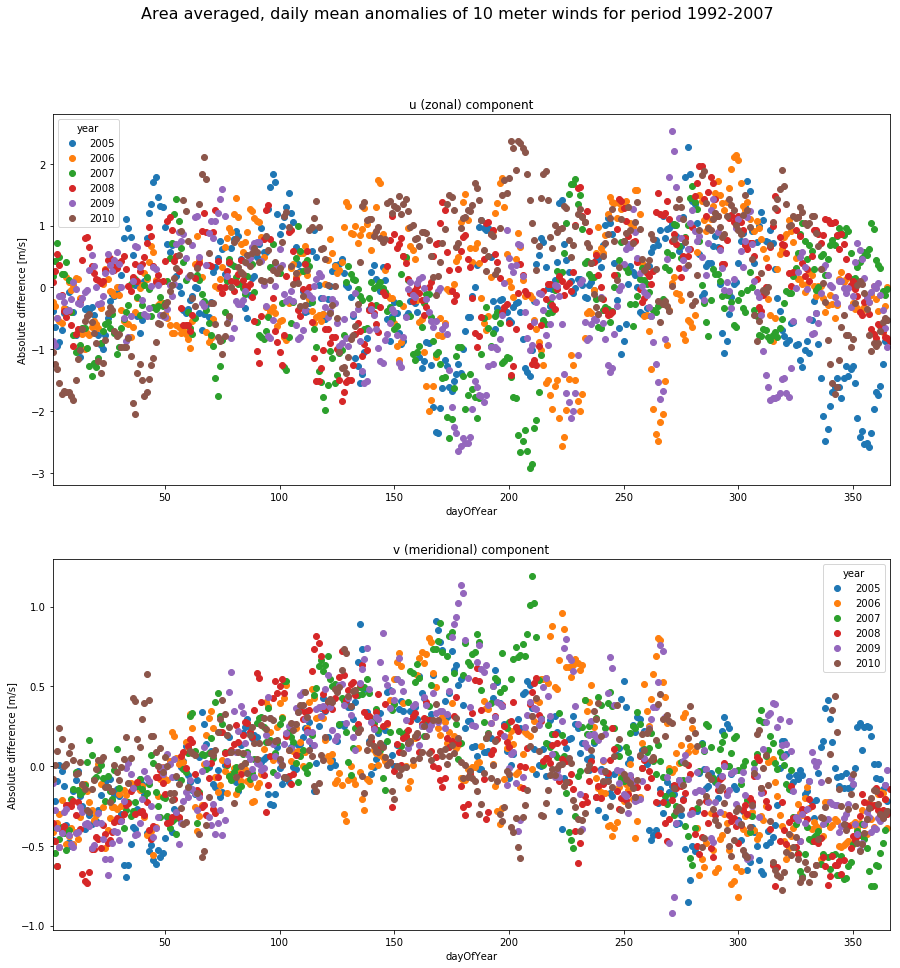

In [108]:
plt.clf()
fig,(ax1,ax2) = plt.subplots(2,figsize=(15,15))
plt.suptitle('Area averaged, daily mean anomalies of 10 meter winds for period 1992-2007',fontsize=16)
anom_df['u10'].plot(ax=ax1,linestyle='',marker='o')
ax1.set_title('u (zonal) component')
ax1.set_ylabel('Absolute difference [m/s]')
anom_df['v10'].plot(ax=ax2,linestyle='',marker='o')
ax2.set_title('v (meridional) component')
ax2.set_ylabel('Absolute difference [m/s]')
plt.show()

Display statistics of each year

In [106]:
anom_df['u10'].describe()

year,2005,2006,2007,2008,2009,2010
count,365.000000,365.000000,365.000000,366.000000,365.000000,365.000000
mean,-0.116219,0.061483,-0.261807,0.202018,-0.237458,0.351429
std,0.934309,0.905021,0.835817,0.734570,0.839222,0.960568
min,-2.574642,-2.563287,-2.921437,-1.839967,-2.641754,-2.045847
25%,-0.703733,-0.522085,-0.731874,-0.289574,-0.736667,-0.367618
50%,-0.093049,0.020970,-0.220463,0.235112,-0.162310,0.553936
75%,0.579360,0.736088,0.299246,0.749384,0.309729,1.099982
max,2.268830,2.135163,1.746116,1.966013,2.524725,2.370301


In [107]:
anom_df['v10'].describe()

year,2005,2006,2007,2008,2009,2010
count,365.000000,365.000000,365.000000,366.000000,365.000000,365.000000
mean,0.009660,-0.024296,0.067964,-0.067263,0.051416,-0.037297
std,0.309443,0.352448,0.380815,0.330839,0.361773,0.284335
min,-0.852311,-0.819056,-0.753344,-0.754009,-0.920580,-0.777815
25%,-0.174985,-0.307175,-0.169738,-0.304975,-0.247471,-0.239494
50%,-0.004601,-0.079373,0.073724,-0.116787,0.019471,-0.003663
75%,0.236240,0.211709,0.301131,0.175756,0.317312,0.160041
max,0.910027,0.957125,1.191683,0.816810,1.134542,0.735077
